In [1]:
initial_path = 'peptide-QML/'
initial_path = '../'

In [2]:
day = "0829"
name_notebook = day + "-sh_em_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

In [8]:
input_data.shape, target_data.shape, input_validation.shape, target_validation.shape

(torch.Size([9000, 4]),
 torch.Size([9000, 1]),
 torch.Size([1000, 4]),
 torch.Size([1000, 1]))

# Quantum node

In [9]:
n_aminoacids = len(string_list[0])

In [10]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    # embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    final_ansatz = qn.parts.Ansatz_final_11,
    measurement = qn.parts.Measurement('Z', (n_aminoacids-1)//2),
    # embedding_n_layers = 4,
    # different_inputs_per_layer = True,
    block_n_layers = 5,
    # wrapper_qlayer = pw.QLayerEmpty,
)

In [11]:
quantum_layer.weights_shape, quantum_layer.input_shape

({'block_weights': (60,), 'final_weights': (12,)}, (4,))

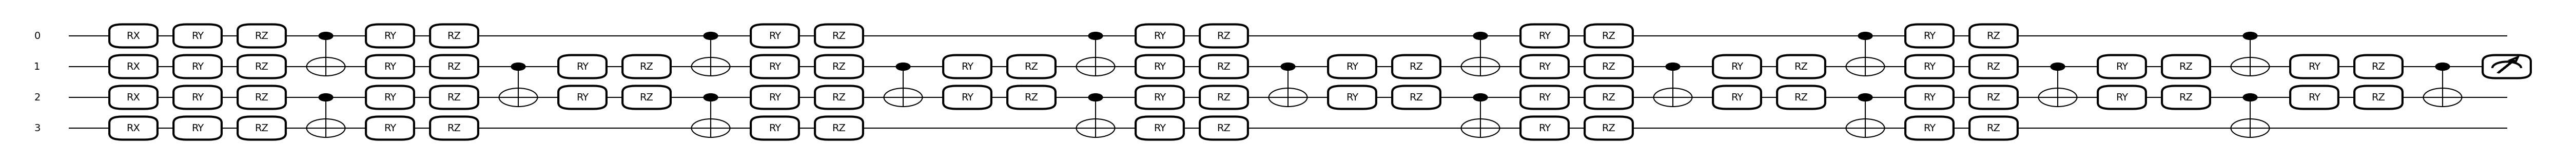

In [12]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [13]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [14]:
import torch.nn as nn
import torch
class ClippedReLU(nn.Module):
    def __init__(self, clip_val=1):
        super(ClippedReLU, self).__init__()
        self.clip_val = clip_val

    def forward(self, x):
        return torch.clamp(x, 0, self.clip_val)
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [15]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer(), ptm.nn.Linear(1,1)]


In [16]:
# layers = []
# for i in range(1, len(layers_dim)):
#     layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
# layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0]), ClippedReLU()]
# layers += [quantum_layer()]
# # layers += [nn.Linear(1, 1)]
# # layers += [nn.Linear(2, 4), nn.ReLU()]
# # layers += [nn.Linear(4, 1)]

In [17]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [18]:
x = input_data[0:2]
for i, layer in enumerate(model.model):
    x = layer(x)
    print(i, x.shape, x)

0 torch.Size([2, 4, 1]) tensor([[[ 0.6740],
         [ 0.0778],
         [-0.9996],
         [-1.5570]],

        [[ 1.6490],
         [ 0.0571],
         [-1.0209],
         [-1.3309]]], grad_fn=<EmbeddingBackward0>)
1 torch.Size([2, 4]) tensor([[ 0.6740,  0.0778, -0.9996, -1.5570],
        [ 1.6490,  0.0571, -1.0209, -1.3309]], grad_fn=<SqueezeBackward0>)
2 torch.Size([2, 1]) tensor([[0.2712],
        [0.3867]], grad_fn=<ReshapeAliasBackward0>)
3 torch.Size([2, 1]) tensor([[0.7156],
        [0.8206]], grad_fn=<AddmmBackward0>)


In [19]:
for i in range(2):
    x = input_data[i]
    for i, layer in enumerate(model.model):
        x = layer(x)
        print(i, x.shape, x)

    print('')

0 torch.Size([4, 1]) tensor([[ 0.6740],
        [ 0.0778],
        [-0.9996],
        [-1.5570]], grad_fn=<EmbeddingBackward0>)
1 torch.Size([4]) tensor([ 0.6740,  0.0778, -0.9996, -1.5570], grad_fn=<SqueezeBackward0>)
2 torch.Size([1]) tensor([0.2712], grad_fn=<CatBackward0>)
3 torch.Size([1]) tensor([0.7156], grad_fn=<AddBackward0>)

0 torch.Size([4, 1]) tensor([[ 1.6490],
        [ 0.0571],
        [-1.0209],
        [-1.3309]], grad_fn=<EmbeddingBackward0>)
1 torch.Size([4]) tensor([ 1.6490,  0.0571, -1.0209, -1.3309], grad_fn=<SqueezeBackward0>)
2 torch.Size([1]) tensor([0.3867], grad_fn=<CatBackward0>)
3 torch.Size([1]) tensor([0.8206], grad_fn=<AddBackward0>)



In [20]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[0.7156],
        [0.8206]], grad_fn=<AddmmBackward0>)
tensor([0.8206], grad_fn=<AddBackward0>)


In [21]:
model.keep_track_params=False,

In [ ]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.SGD,
    optimizer_options={'lr': 0.1},
    num_epochs = 50,                
    batch_size = 32,
)

Epoch [0/50], Loss: 3.9024, Loss validation: 4.2991
	 Validation string, 	 i: 0; 	 prediction: -7.6493, 	 target: -0.0638, 	 loss: 118.8674
	 Validation string, 	 i: 1; 	 prediction: -7.4469, 	 target: 0.0382, 	 loss: 195.8275
	 Validation string, 	 i: 2; 	 prediction: -7.4332, 	 target: -0.0721, 	 loss: 102.1149
Epoch [1/50], Loss: 32.2758, Loss validation: 66.0512, Time remaining: ~0.0h 28.0m 10s
	 Validation string, 	 i: 0; 	 prediction: 3.1436, 	 target: -0.0638, 	 loss: 50.2609
	 Validation string, 	 i: 1; 	 prediction: 3.2288, 	 target: 0.0382, 	 loss: 83.4729
	 Validation string, 	 i: 2; 	 prediction: 3.2878, 	 target: -0.0721, 	 loss: 46.6084
Epoch [2/50], Loss: 32.0324, Loss validation: 30.0394, Time remaining: ~0.0h 26.0m 59s
	 Validation string, 	 i: 0; 	 prediction: 1.9644, 	 target: -0.0638, 	 loss: 31.7820
	 Validation string, 	 i: 1; 	 prediction: 2.2267, 	 target: 0.0382, 	 loss: 57.2561
	 Validation string, 	 i: 2; 	 prediction: 1.8267, 	 target: -0.0721, 	 loss: 26.34

KeyboardInterrupt: 

In [ ]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
        "Quantum_circuit": quantum_layer.__str__(),
    }
)

The file ../checkpoints/0829/txts/0829-sh_em_1qm_model_str_5.txt already exists, it will be replaced
Saved in:  ../checkpoints/0829/txts/0829-sh_em_1qm_model_str_5.txt


Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_losses_batches_4.png


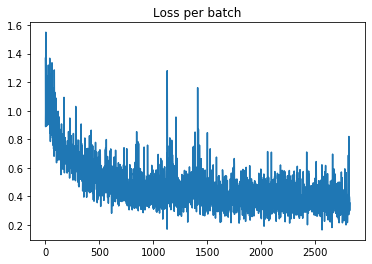

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_losses_epoch_4.png


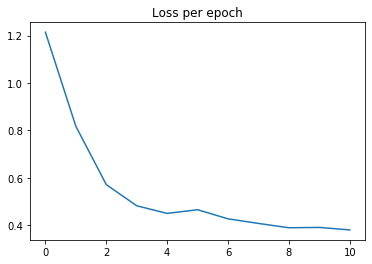

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_losses_epoch_validation_4.png


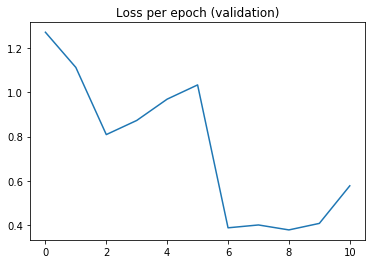

In [ ]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True)

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_0.weight_None_4.png


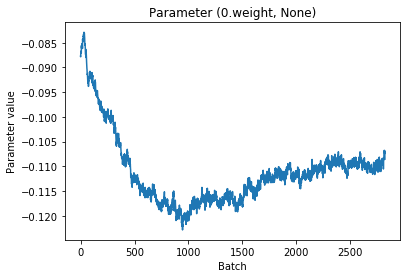

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_2.embedding_weights_None_4.png


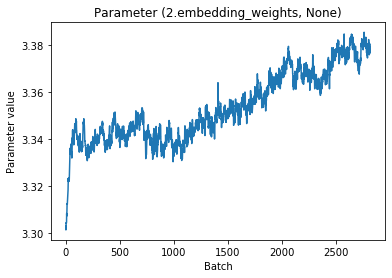

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_2.block_weights_None_4.png


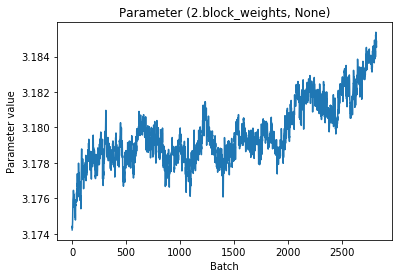

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_3.weight_None_4.png


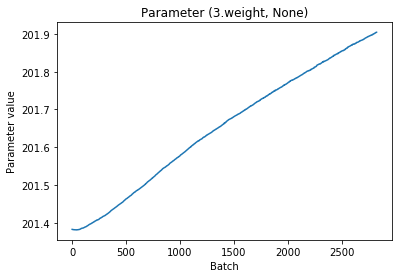

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_3.bias_None_4.png


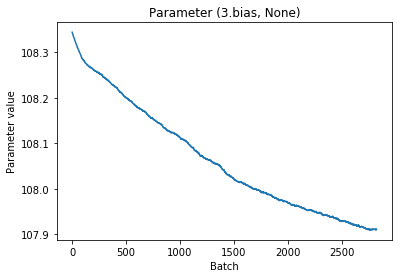

In [ ]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

In [ ]:
# model.plot_parameter(layer='7.weights', index=50)

In [ ]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

Model saved as peptide-QML/checkpoints/0810/models/0810-sh_em_1qm_v2_4.pth


In [ ]:
model.plot_validation(save=True, fig_size=(9,9))

UnboundLocalError: local variable 'data_X_validation' referenced before assignment

In [ ]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: -78.0800, 	 prediction: -8.6502, 	 loss: 0.8892
i: 1, 		 target: -42.4080, 	 prediction: -30.0594, 	 loss: 0.2912
i: 2, 		 target: 220.1500, 	 prediction: 144.8587, 	 loss: 0.3420
i: 3, 		 target: -69.5500, 	 prediction: -28.4424, 	 loss: 0.5911
i: 4, 		 target: -101.6020, 	 prediction: -48.9109, 	 loss: 0.5186
i: 5, 		 target: -95.9410, 	 prediction: -36.1902, 	 loss: 0.6228
i: 6, 		 target: -83.9420, 	 prediction: -37.2878, 	 loss: 0.5558
i: 7, 		 target: 174.9550, 	 prediction: 191.8207, 	 loss: 0.0964
i: 8, 		 target: 453.8340, 	 prediction: 213.4433, 	 loss: 0.5297
i: 9, 		 target: 213.2580, 	 prediction: 166.9855, 	 loss: 0.2170
i: 10, 		 target: -101.1460, 	 prediction: -25.7691, 	 loss: 0.7452
i: 11, 		 target: -73.6810, 	 prediction: -37.6033, 	 loss: 0.4896
i: 12, 		 target: 51.8760, 	 prediction: -51.9949, 	 loss: 2.0023
i: 13, 		 target: 118.4490, 	 prediction: 127.3110, 	 loss: 0.0748
i: 14, 		 target: -97.8780, 	 prediction: -4.2466, 	 loss: 0.9566
i: 15,

In [ ]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main 5e76f65c] data trained model
 14 files changed, 1042 insertions(+), 1 deletion(-)
 create mode 100644 checkpoints/0809/models/0809-sh_em_1qm_v2_3.pth
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_batches_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_epoch_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_epoch_validation_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_0.weight_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_2.block_weights_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_2.embedding_weights_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_3.bias_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_3.weight_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_validation_2.png
 create mode 100644 checkpoints/0809/plots